# FIT5196 Assessment 3

- Student Name: Jiawei Ren

- Student ID: 32073119

## Table of Content
 
* [Task 1 : Data Integration](#task1)
    * [1.1 load data and create dataframe](#task11)
    * [1.2 parse xml file](#task12)
    * [1.3 create columns and set default value](#task13)
    * [1.4 assign suburb to address](#task14)
    * [1.5 calculate  closest_train_station_id and distance_to_closest_train_station](#task15)
    * [1.6 Calculate travel_min_to_MC and direct_journey_flag](#task16)
    * [1.7 web scraping](#task17)
* [Task 2 data re-shaping](#task2)
    * [2.1 Extract data for shaping](#task21)
    * [2.2 Check Distribution](#task22)
    * [2.3 Check Outlier](#task23)
    * [2.4 Scaling](#task24)
    * [2.5 Transformations](#task25)
    * [2.6 linear relationship between features and House_quarterly_growth](#task26)
    * [2.7 Regression test](#task27)
* [Reference](#reference)

## Library

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
#!pip install pyshp
import shapefile as shp
import matplotlib
import matplotlib.path as mplPath
import xml.etree.ElementTree as ET
from math import sin, cos, sqrt, atan2, radians, log
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from scipy.special import logit
from scipy import stats

## Task 1 : Data Integration  <a class="anchor" id="task1"></a>


### 1.1 load data and create dataframe <a class="anchor" id="task11"></a>

- The xml file cannot be opened, I checked the file and it seems like it's because there is no root; & should be changed to ''&amp;''

In [2]:
#store texts from 332073119_realstate.xml
my_xml = []
with open('32073119_realstate.xml') as f:
    for line in f:
        # fix the text issue
        fix_line = line.replace('&','&amp;')
        my_xml.append(fix_line)
    f.close()
#create a new file and add a root 
with open('fixed_32073119_realstate.xml','a') as f:
    f.write("<properties>\n")
    for line in my_xml:
        string = '    ' + line
        f.write(string)
    f.write("</properties>\n")
    f.close()   

### 1.2 parse xml file <a class="anchor" id="task12"></a>

In [3]:
xml_data = open('fixed_32073119_realstate.xml', 'r').read() 
root = ET.XML(xml_data)
# list for dataframe attributes
property_id  = []
lat  = []
lng =[]
addr_street = []
for i, attribute  in enumerate(root):
    # match the attribute and store information
    for info in attribute:
        if  info.tag == 'property_id':
            property_id.append(info.text)
        elif info.tag == 'lat':
            lat.append(info.text)
        elif info.tag == 'lng':
            lng.append(info.text)
        elif info.tag == 'addr_street':
            addr_street.append(info.text)
        else:
            # in case, If there are any strange errors
            print(info.tag,info.text)
# convert to pandas dataframe
data = [property_id,lat,lng,addr_street]       
df = pd.DataFrame(data).T 
cols = ['property_id','lat','lng','addr_street']
df.columns = cols

In [4]:
# check data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  1098 non-null   object
 1   lat          1098 non-null   object
 2   lng          1098 non-null   object
 3   addr_street  1098 non-null   object
dtypes: object(4)
memory usage: 34.4+ KB


In [5]:
#change the data type of lat and lng to float
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'] .astype(float)

In [6]:
# check duplicated values
address = df['addr_street']
df[address.isin(address[address.duplicated()])]

,property_id,lat,lng,addr_street
2,12980,-37.694174,144.758153,32 Dundee Way
158,37294,-37.640824,145.027150,31 Park Street
177,30333,-37.777395,144.990960,7 Bridge Street
219,12980,-37.694174,144.758153,32 Dundee Way
373,87018,-37.891573,145.001831,7 Bridge Street
754,30064,-37.778674,145.013645,402 Clarke Street
799,30064,-37.778674,145.013645,402 Clarke Street
974,85524,-37.879506,145.012628,31 Park Street


these are duplicated values, by row number, I will remove 2 158,177 and 754

In [7]:
pos = [2,158,177,754]
df.drop(df.index[pos], inplace = True)
df.reset_index(drop=True, inplace=True)

### 1.3 create columns, set default value and parse shipefile<a class="anchor" id="task13"></a>

In [8]:
# add columns to dataframe and set defualt values
df['suburb'] = 'not available'
df['closest_train_station_id'] = 0
df['distance_to_closest_train_station'] = 0
df['travel_min_to_MC'] = -1
df['direct_journey_flag'] = -1
df['House_report'] = 'not extracted'
df['Median_house_price'] = 'not extracted'
df['House_quarterly_growth'] = 'not extracted'
df['House_twelve_month_growth'] = 'not extracted'
df['House_average_annual_growth'] = 'not extracted'

In [9]:
# read shapefile and extract suburb name and it's boundary coordinat
shape = shp.Reader("VIC_LOCALITY_POLYGON_shp.shp")
#shape.shapeRecords()[0].shape.__geo_interface__
#shape.records()
suburb_name = []
suburb_coordinates = []
for record in range(len(shape)):
    coordinate = shape.shapeRecords()[record].shape.__geo_interface__
    suburb_name.append(shape.records()[record][6])
    suburb_coordinates.append(coordinate['coordinates'])
suburb_df = pd.DataFrame([suburb_name,suburb_coordinates]).T 
cols = ['suburb_name','suburb_coordinates']
suburb_df.columns = cols

In [10]:
suburb_df

,suburb_name,suburb_coordinates
0,UNDERBOOL,"[[(141.74552399, -35.07228701), (141.74552471,..."
1,NURRAN,"[[(148.668767, -37.39571245), (148.66876202, -..."
2,WOORNDOO,"[[(142.92287999, -37.97885997), (142.90449196,..."
3,DEPTFORD,"[[(147.82335712, -37.66000897), (147.8231274, ..."
4,YANAC,"[[(141.279783, -35.99858911), (141.27988533, -..."
...,...,...
2968,MELBOURNE AIRPORT,"[[(144.86381998, -37.67087296), (144.86405203,..."
2969,BULLA,"[[(144.80216701, -37.66167496), (144.80243207,..."
2970,SOMERS,"[[(145.19210902, -38.39104797), (145.19391599,..."
2971,HMAS CERBERUS,"[[(145.218314, -38.38722212), (145.21863318, -..."


In [11]:
#found some duplicated value
suburb_df.describe()

,suburb_name,suburb_coordinates
count,2973,2973
unique,2957,2973
top,GOLDEN POINT,"[[(143.82348703, -37.51756103), (143.82326303,..."
freq,3,1


In [12]:
suburb_df.drop_duplicates(subset=['suburb_name'],inplace=True) 
suburb_df.reset_index(drop=True, inplace=True)

### 1.4 assign suburb to address <a class="anchor" id="task14"></a>


In [13]:
for x in range(len(df)):
    # extract the coordinate of the address
    coordinate = [df['lng'][x],df['lat'][x]]
    for i in range(len(suburb_df)):
        #use mplPath.Path function to find the suburb
        poly_path = mplPath.Path(suburb_df['suburb_coordinates'][i][0])
        if poly_path.contains_point(coordinate):
            df.at[x,'suburb'] = suburb_df['suburb_name'][i]
            break


In [14]:
df

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,73532,-37.849075,145.303972,31 Dorrigo Drive,BORONIA,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1,2194,-37.819211,144.845848,35 Corrigan Avenue,BROOKLYN,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
2,7687,-37.749161,144.763885,95 Fairfax Circuit,ALBANVALE,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
3,3210,-37.814997,144.867631,25A Sanderson Street,YARRAVILLE,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
4,29142,-37.805721,144.994252,89 Park Street,ABBOTSFORD,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,20004,-37.799680,144.969291,1/29 University Street,CARLTON,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1090,31154,-37.759390,145.023968,335 Rossmoyne Street,THORNBURY,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1091,62352,-37.797901,145.243195,85 Mullum Mullum Road,RINGWOOD,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1092,52990,-37.823749,144.992299,30 Wangaratta Street,RICHMOND,0,0,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted


<AxesSubplot:>

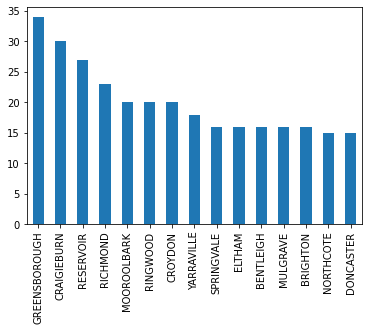

In [15]:
df['suburb'].value_counts().head(15).plot(kind = 'bar')

### 1.5 calculate  closest_train_station_id and distance_to_closest_train_station <a class="anchor" id="task15"></a>

In [16]:
stops  = pd.read_csv('stops.txt')

In [17]:
# function for  haversine_distances
def haversine_distances(lati1,long1,lati2,long2):
    
    R = 6378.0 #radius of the earth.

    lat1 = radians(lati1)
    lon1 = radians(long1)
    lat2 = radians(lati2)
    lon2 = radians(long2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2.0)**2.0 + cos(lat1) * cos(lat2) * sin(dlon / 2.0)**2.0
    c = 2.0 * atan2(sqrt(a), sqrt(1.0 - a))

    distance = R * c
    return distance

In [18]:
# change the datatype of distance_to_closest_train_station to float
df['distance_to_closest_train_station'] = pd.to_numeric(df['distance_to_closest_train_station'], downcast="float")
for row in range(len(df)):
    # extract coordinates of the property and station
    distances = []
    lati1= df['lat'][row]
    long1= df['lng'][row]
    #calculate the distance to all station
    for station in range(len(stops)):
        lati2= stops['stop_lat'][station]
        long2= stops['stop_lon'][station]
        distance = haversine_distances(lati1,long1,lati2,long2)
        distances.append(distance)
    #find the minimum distance and the closet station
    df.at[row,'closest_train_station_id'] = stops['stop_id'][distances.index(min(distances))]
    df.at[row,'distance_to_closest_train_station'] = min(distances)
df   

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,73532,-37.849075,145.303972,31 Dorrigo Drive,BORONIA,19869,2.137181,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1,2194,-37.819211,144.845848,35 Corrigan Avenue,BROOKLYN,20022,2.682856,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
2,7687,-37.749161,144.763885,95 Fairfax Circuit,ALBANVALE,20002,3.219047,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
3,3210,-37.814997,144.867631,25A Sanderson Street,YARRAVILLE,20022,1.800611,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
4,29142,-37.805721,144.994252,89 Park Street,ABBOTSFORD,19976,0.140177,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,20004,-37.799680,144.969291,1/29 University Street,CARLTON,19842,1.284950,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1090,31154,-37.759390,145.023968,335 Rossmoyne Street,THORNBURY,19932,2.152946,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1091,62352,-37.797901,145.243195,85 Mullum Mullum Road,RINGWOOD,19879,1.682450,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted
1092,52990,-37.823749,144.992299,30 Wangaratta Street,RICHMOND,19908,0.191171,-1,-1,not extracted,not extracted,not extracted,not extracted,not extracted


In [19]:
# extract Melbourne central station's id
mc_id = stops.at[stops[stops['stop_name']== 'Melbourne Central Railway Station'].index[0], 'stop_id']

In [20]:
trips  = pd.read_csv('trips.txt')
trips

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
23804,2-WMN-F-mjp-1,UJ_2,17072252.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23805,2-WMN-F-mjp-1,UJ_2,17072256.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23806,2-WMN-F-mjp-1,UJ_2,17072260.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23807,2-WMN-F-mjp-1,UJ_2,17072264.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1


### 1.6 Calculate travel_min_to_MC and direct_journey_flag <a class="anchor" id="task16"></a>

In [21]:
#load data
service = pd.read_csv('calendar.txt')
stop_times  = pd.read_csv('stop_times.txt')
#extract weekday service id
weekday = service[(service['saturday']!=1) & (service['sunday']!=1) ]['service_id'].tolist()
extract1  = trips[['trip_id','service_id']]
# assign trip id to trip by merge trips and stop_times
stop_times = pd.merge(extract1, stop_times, on='trip_id')
stop_times

,trip_id,service_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17067982.T0.2-ALM-F-mjp-1.1.H,T0,05:01:00,05:01:00,19847,1,NaN,0,0,0.000000
1,17067982.T0.2-ALM-F-mjp-1.1.H,T0,05:02:00,05:02:00,19848,2,NaN,0,0,723.017818
2,17067982.T0.2-ALM-F-mjp-1.1.H,T0,05:04:00,05:04:00,19849,3,NaN,0,0,1951.735072
3,17067982.T0.2-ALM-F-mjp-1.1.H,T0,05:06:00,05:06:00,19850,4,NaN,0,0,2899.073349
4,17067982.T0.2-ALM-F-mjp-1.1.H,T0,05:08:00,05:08:00,19851,5,NaN,0,0,3927.090952
...,...,...,...,...,...,...,...,...,...,...
390300,17072264.UJ.2-WMN-F-mjp-1.6.R,UJ_2,24:07:00,24:07:00,19991,4,NaN,0,0,3641.811422
390301,17072268.UJ.2-WMN-F-mjp-1.6.R,UJ_2,24:31:00,24:31:00,19994,1,NaN,0,0,0.000000
390302,17072268.UJ.2-WMN-F-mjp-1.6.R,UJ_2,24:33:00,24:33:00,19993,2,NaN,0,0,1702.554760
390303,17072268.UJ.2-WMN-F-mjp-1.6.R,UJ_2,24:35:00,24:35:00,19992,3,NaN,0,0,2598.738912


In [22]:
# for calculated stations
calculated_list = []
for i in range(len(df)):
    # get the closet station id
    station = df['closest_train_station_id'][i]
    #list to store trip time
    trip_time = []
    # if this station is not calculated 
    if station not in calculated_list and station !=mc_id:
        calculated_list.append(station)
        #get a trip list for the closet station when the depature time is 7-9am and during weekdays
        valid_trips = stop_times['trip_id'].loc[(stop_times['stop_id'] == station) & (stop_times['service_id'].isin(weekday)) &
                      (stop_times['departure_time']<'09:00:00')& (stop_times['departure_time']> '07:00:00')].unique().tolist()
        for trip in range(len(valid_trips)):
            #get a dataframe for this trip and extract melbourne central station or closet station 
            data = stop_times.loc[(stop_times['trip_id'] == valid_trips[trip]) 
                                  & ((stop_times['stop_id'] == station) | (stop_times['stop_id'] == mc_id)) ]
            #if we find both stations
            if len(data) == 2:
                #make sure melbourne central is the destination by compare the stop sequence
                if data[data['stop_id'] == station]['stop_sequence'].values[0] < data[data['stop_id'] == mc_id]['stop_sequence'].values[0]:
                    #calculate travel time
                    time_1 = datetime.strptime(data[data['stop_id'] == station]['departure_time'].values[0],"%H:%M:%S")
                    time_2 = datetime.strptime(data[data['stop_id'] == mc_id]['arrival_time'].values[0],"%H:%M:%S")
                    time = ((time_2 - time_1).seconds/60)
                    trip_time.append(time)
        #all trips are calculated now 
        #get average value
        #means no direct journey or no journey 
        if len(trip_time) == 0:
            ave_time = 'Not available'
        else:
            ave_time = int(sum(trip_time)/len(trip_time))
        #same station should have same travel_min_to_MC value
        df.loc[df['closest_train_station_id'] == station, 'travel_min_to_MC'] = ave_time
# if the closet station is melbourne centre
df.loc[df['closest_train_station_id'] == mc_id, 'travel_min_to_MC'] = 0
#if it is not available
df.loc[df['travel_min_to_MC'] == -1, 'travel_min_to_MC'] = 'not available'

In [23]:
# if there is a direct journey, then travel_min_to_MC is not not available
df.loc[df['travel_min_to_MC'] != 'Not available', 'direct_journey_flag'] = 1
# if there is no direct trip, then travel_min_to_MC is not available
df.loc[df['travel_min_to_MC'] == 'Not available', 'direct_journey_flag'] = 0
df

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,73532,-37.849075,145.303972,31 Dorrigo Drive,BORONIA,19869,2.137181,44,1,not extracted,not extracted,not extracted,not extracted,not extracted
1,2194,-37.819211,144.845848,35 Corrigan Avenue,BROOKLYN,20022,2.682856,16,1,not extracted,not extracted,not extracted,not extracted,not extracted
2,7687,-37.749161,144.763885,95 Fairfax Circuit,ALBANVALE,20002,3.219047,27,1,not extracted,not extracted,not extracted,not extracted,not extracted
3,3210,-37.814997,144.867631,25A Sanderson Street,YARRAVILLE,20022,1.800611,16,1,not extracted,not extracted,not extracted,not extracted,not extracted
4,29142,-37.805721,144.994252,89 Park Street,ABBOTSFORD,19976,0.140177,17,1,not extracted,not extracted,not extracted,not extracted,not extracted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,20004,-37.799680,144.969291,1/29 University Street,CARLTON,19842,1.284950,0,1,not extracted,not extracted,not extracted,not extracted,not extracted
1090,31154,-37.759390,145.023968,335 Rossmoyne Street,THORNBURY,19932,2.152946,29,1,not extracted,not extracted,not extracted,not extracted,not extracted
1091,62352,-37.797901,145.243195,85 Mullum Mullum Road,RINGWOOD,19879,1.682450,37,1,not extracted,not extracted,not extracted,not extracted,not extracted
1092,52990,-37.823749,144.992299,30 Wangaratta Street,RICHMOND,19908,0.191171,5,1,not extracted,not extracted,not extracted,not extracted,not extracted


<AxesSubplot:>

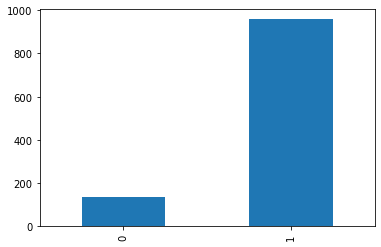

In [24]:
df['direct_journey_flag'].value_counts().sort_values().plot(kind = 'bar')

### 1.7 web scraping <a class="anchor" id="task17"></a>

In [25]:
#get the link
html = urlopen("https://www.yourinvestmentpropertymag.com.au")
bsobj = BeautifulSoup(html, "lxml")

In [26]:
# We are interested in victoria suburbs so I would like to find anything related to suburbs and vic on this page
for l in bsobj.find_all('a', href=re.compile(r"(?=.*suburb)(?=.*vic)")):
    if 'href' in l.attrs:
        print(l.attrs['href'])

/top-suburbs/vic/market-reports/
/top-suburbs/vic-3216-highton.aspx


In [27]:
# how about top_suburbs?
for l in bsobj.find_all('a', href=re.compile("^(/top-suburbs/)((?!:).)*$")):
    if 'href' in l.attrs:
        print(l.attrs['href'])    

/top-suburbs/
/top-suburbs/
/top-suburbs/nsw/market-reports/
/top-suburbs/vic/market-reports/
/top-suburbs/qld/market-reports/
/top-suburbs/sa/market-reports/
/top-suburbs/wa/market-reports/
/top-suburbs/act/market-reports/
/top-suburbs/nt/market-reports/
/top-suburbs/tas/market-reports/
/top-suburbs/
/top-suburbs/qld-4850-taylors-beach.aspx
/top-suburbs/act-2614-cook.aspx
/top-suburbs/wa-6100-lathlain.aspx
/top-suburbs/qld-4218-mermaid-waters.aspx
/top-suburbs/vic-3216-highton.aspx
/top-suburbs/
/top-suburbs/
/top-suburbs/
/top-suburbs/


In [28]:
# I want to have a look at /top-suburbs/ first
html = urlopen("https://www.yourinvestmentpropertymag.com.au/top-suburbs/")
bsobj = BeautifulSoup(html, "lxml")
for l in bsobj.find_all('a', href=re.compile(r"(?=.*suburb)(?=.*vic)")):
    if 'href' in l.attrs:
        print(l.attrs['href'])

/top-suburbs/vic/market-reports/
/top-suburbs/vic-3216-highton.aspx
/top-suburbs/vic-3956-tarwin-lower.aspx
/top-suburbs/vic-3166-oakleigh.aspx
/top-suburbs/vic-3134-warranwood.aspx
/top-suburbs/vic-3033-keilor-east.aspx
/top-suburbs/vic-3851-loch-sport.aspx
/top-suburbs/vic-3754-mernda.aspx
/top-suburbs/vic-3691-leneva.aspx
/top-suburbs/vic-3644-cobram.aspx
/top-suburbs/vic-3145-malvern-east.aspx
/top-suburbs/vic/
/top-suburbs/vic/market-reports/


In [29]:
#then have a look at /top-suburbs/vic/
html = urlopen("https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic/")
bsobj = BeautifulSoup(html, "lxml")
#theses are the links for suburb reports 
suburb_link = []
for l in bsobj.find_all('a', href=re.compile(r"(?=.*suburb)(?=.*vic-)")):
    if 'href' in l.attrs:
        suburb_link.append(l.attrs['href'])
        print(l.attrs['href'])

/top-suburbs/vic-3067-abbotsford.aspx
/top-suburbs/vic-3040-aberfeldie.aspx
/top-suburbs/vic-3825-aberfeldy.aspx
/top-suburbs/vic-3714-acheron.aspx
/top-suburbs/vic-3352-addington.aspx
/top-suburbs/vic-3465-adelaide-lead.aspx
/top-suburbs/vic-3962-agnes.aspx
/top-suburbs/vic-3231-aireys-inlet.aspx
/top-suburbs/vic-3851-airly.aspx
/top-suburbs/vic-3042-airport-west.aspx
/top-suburbs/vic-3021-albanvale.aspx
/top-suburbs/vic-3206-albert-park.aspx
/top-suburbs/vic-3971-alberton.aspx
/top-suburbs/vic-3971-alberton-west.aspx
/top-suburbs/vic-3020-albion.aspx
/top-suburbs/vic-3714-alexandra.aspx
/top-suburbs/vic-3350-alfredton.aspx
/top-suburbs/vic-3871-allambee-reserve.aspx
/top-suburbs/vic-3691-allans-flat.aspx
/top-suburbs/vic-3277-allansford.aspx
/top-suburbs/vic-3364-allendale.aspx
/top-suburbs/vic-3305-allestree.aspx
/top-suburbs/vic-3465-alma.aspx
/top-suburbs/vic-3979-almurta.aspx
/top-suburbs/vic-3078-alphington.aspx
/top-suburbs/vic-3018-altona.aspx
/top-suburbs/vic-3025-altona-east

In [30]:
sub_list = df['suburb'].unique().tolist()

for subs in sub_list:
    #get a suburb and use regular expression to find the link from link lisk
    sub = subs.replace(' ','-').lower()
    reg = re.compile(sub)
    link = list(filter(reg.findall, suburb_link))
    #house report
    s_link = 'https://www.yourinvestmentpropertymag.com.au'+link[0]
    html = urlopen(str(s_link))
    bsobj = BeautifulSoup(html, "lxml")
    house_report = bsobj.find_all("div", {"id":"ContentPlaceHolder1_ContentPlaceHolder1_contentHouse"})
    #if there is no report, then assign 'Not Available'
    if len(house_report) == 0:
        df.loc[df['suburb'] == subs, "House_report"] = 'Not Available'
    else:
        report = ''
        for i in house_report[0].find_all('p'):
            report = report + i.text
        df.loc[df['suburb'] == subs, "House_report"] = report
    #median house price:
    median_house_price = bsobj.find_all("td", {"class":"align_r House Median"})
    if len(median_house_price) == 0:
        df.loc[df['suburb'] == subs, "Median_house_price"] = 'N/A'
    else:
        df.loc[df['suburb'] == subs, "Median_house_price"] = median_house_price[0].text.strip()
    #quarterly_growth
    quarterly_growth = bsobj.find_all("td", {"class":"align_r House QuarterlyGrowth"})
    if len(quarterly_growth) == 0:
        df.loc[df['suburb'] == subs, "House_quarterly_growth"] = 'N/A'
    else:
        df.loc[df['suburb'] == subs, "House_quarterly_growth"] = quarterly_growth[0].text.strip()
    #House_twelve_month_growth
    twelve_month_growth = bsobj.find_all("td", {"class":"align_r House 1yr"})
    if len(twelve_month_growth) == 0:
        df.loc[df['suburb'] == subs, "House_twelve_month_growth"] = 'N/A'
    else:
        df.loc[df['suburb'] == subs, "House_twelve_month_growth"] = twelve_month_growth[0].text.strip()
    #average_annual_growth
    average_annual_growth = bsobj.find_all("td", {"class":"align_r House MedianGrowthThisYr"})
    if len(average_annual_growth) == 0:
        df.loc[df['suburb'] == subs, "House_average_annual_growth"] = 'N/A'
    else:
        df.loc[df['suburb'] == subs, "House_average_annual_growth"] = average_annual_growth[0].text.strip()

In [31]:
df

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,73532,-37.849075,145.303972,31 Dorrigo Drive,BORONIA,19869,2.137181,44,1,If you compare the increase in value of invest...,"$820,000",11.29%,21.05%,5.73%
1,2194,-37.819211,144.845848,35 Corrigan Avenue,BROOKLYN,20022,2.682856,16,1,Investment property in Brooklyn has done aroun...,"$860,000",10.83%,16.39%,2.91%
2,7687,-37.749161,144.763885,95 Fairfax Circuit,ALBANVALE,20002,3.219047,27,1,Giving property investors a a stable capital ...,"$600,000",10.02%,22.54%,9.31%
3,3210,-37.814997,144.867631,25A Sanderson Street,YARRAVILLE,20022,1.800611,16,1,"Over the last year, property investments in Ya...","$1,175,000",11.56%,46.67%,9.63%
4,29142,-37.805721,144.994252,89 Park Street,ABBOTSFORD,19976,0.140177,17,1,Giving property investors a a solid capital g...,"$1,297,500",14.17%,26.64%,7.51%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,20004,-37.799680,144.969291,1/29 University Street,CARLTON,19842,1.284950,0,1,With a capital gain of 14.77% for the last 12 ...,"$1,470,000",11.81%,14.77%,6.51%
1090,31154,-37.759390,145.023968,335 Rossmoyne Street,THORNBURY,19932,2.152946,29,1,Thornbury is an average performer in VIC when ...,"$1,420,000",10.42%,26.19%,5.99%
1091,62352,-37.797901,145.243195,85 Mullum Mullum Road,RINGWOOD,19879,1.682450,37,1,At number 1335th in the list of Australian sub...,"$996,500",11.58%,21.79%,0.09%
1092,52990,-37.823749,144.992299,30 Wangaratta Street,RICHMOND,19908,0.191171,5,1,At number 407th in the list of Australian subu...,"$1,425,000",14.29%,33.33%,8.31%


## Task 2 data re-shaping <a class="anchor" id="task2"></a>

### Attribute description （from estate website）

#### Median price: 

is calculated by compiling all the property sale prices in a suburb during the past 12 months
and then taking the middle figure. It is a good
measure to detect changes in the market by way
of price movement.

#### Quarterly growth3-mth growth (%)

is the percentage change in the median price
over the last three months, and is a good
short-term indicator of whether property prices
in that suburb are currently rising or falling,
although this can be volatile in nature

#### 12-mth growth (%)

is the percentage change in the median
price over the last 12 months, and shows
how the market has moved over the medium
term. Anything over 10 would represent very
strong growth.

#### Average annual growth (%)

is the average percentage change in the median
price over the last 10 years, expressed as a
per-annum figure. This statistic irons out the
shorter-term peaks and troughs in the market
to give a good measure of long-term market
performance. Anything over 7.5 would indicate
exceptionally strong growth (more than a
doubling in price over the full 10 years).


### 2.1 Extract data for shaping <a class="anchor" id="task21"></a>

we can see they are using different scale, one is dollar, others are percentage.Median_house_price is much larger than other features and outweighs the importance of other features, so **feature scaling** is necessary

In [32]:
# lets grab all unique rows by suburb
# select features
part2_df = df.drop_duplicates(subset=['suburb'])
part2_df.reset_index(drop=True, inplace=True)
part2_df = part2_df[['Median_house_price','House_quarterly_growth','House_twelve_month_growth','House_average_annual_growth']]
#remove null
part2_df.drop(part2_df[part2_df.Median_house_price == 'N/A'].index, inplace=True)
part2_df.reset_index(drop=True, inplace=True)
part2_df

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,"$820,000",11.29%,21.05%,5.73%
1,"$860,000",10.83%,16.39%,2.91%
2,"$600,000",10.02%,22.54%,9.31%
3,"$1,175,000",11.56%,46.67%,9.63%
4,"$1,297,500",14.17%,26.64%,7.51%
...,...,...,...,...
151,"$1,310,000",12.50%,4.02%,4.89%
152,"$967,000",11.22%,24.22%,12.73%
153,"$3,150,000",13.33%,0.00%,3.84%
154,"$751,500",10.78%,0.00%,-0.33%


In [33]:
#Convert them to numeric values
for row in range(len(part2_df)):
    part2_df.at[row,'Median_house_price'] = pd.to_numeric(part2_df['Median_house_price'][row][1:].replace(',',''))
    part2_df.at[row,'House_quarterly_growth'] = pd.to_numeric(part2_df['House_quarterly_growth'][row].
                                                              replace('.','').replace('%',''))/10000
    part2_df.at[row,'House_twelve_month_growth'] = pd.to_numeric(part2_df['House_twelve_month_growth'][row].
                                                                 replace('.','').replace('%',''))/10000
    part2_df.at[row,'House_average_annual_growth'] = pd.to_numeric(part2_df['House_average_annual_growth'][row].
                                                                   replace('.','').replace('%',''))/10000
#find and remove null values
part2_df = part2_df.replace(0, np.nan)
part2_df = part2_df.dropna()
part2_df.reset_index(drop=True, inplace=True)
part2_df

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,820000,0.1129,0.2105,0.0573
1,860000,0.1083,0.1639,0.0291
2,600000,0.1002,0.2254,0.0931
3,1175000,0.1156,0.4667,0.0963
4,1297500,0.1417,0.2664,0.0751
...,...,...,...,...
137,620000,0.1379,0.3750,0.0974
138,681500,0.1004,0.1375,0.0578
139,1310000,0.1250,0.0402,0.0489
140,967000,0.1122,0.2422,0.1273


### 2.2 Check Distribution <a class="anchor" id="task22"></a>

- these features are not normally distributed, most of them are skewed

- Usually, we prefer normally distributed data for modelling and analysis. Because it is easier to interpret



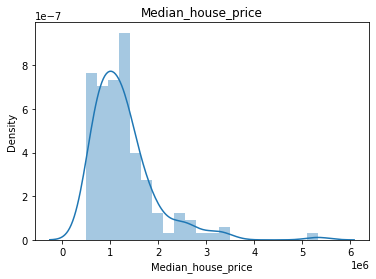

the skewness is :  2.4125994188098123


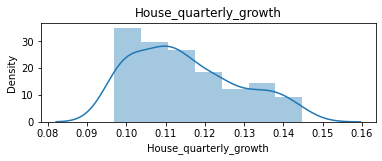

the skewness is :  0.5319360521144282


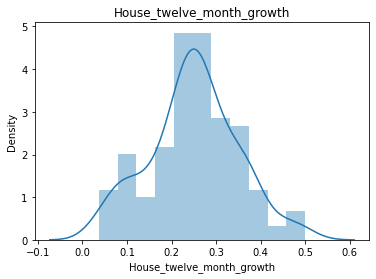

the skewness is :  -0.0034183233093052472


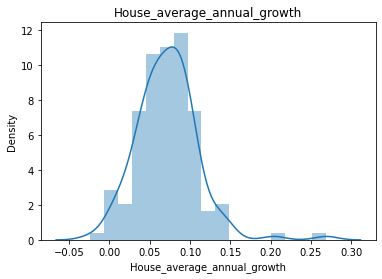

the skewness is :  1.111666651531243


In [34]:
def plot_hists(part2_df):
    # For Median_house_price
    sns.distplot(part2_df['Median_house_price'])
    plt.title('Median_house_price')
    plt.show()
    print('the skewness is : ',part2_df['Median_house_price'].skew())
    # For House_quarterly_growth
    plt.subplot(2, 1, 1)
    sns.distplot(part2_df['House_quarterly_growth'])
    plt.title('House_quarterly_growth')
    plt.show()
    print('the skewness is : ',part2_df['House_quarterly_growth'].skew())  
    # For House_twelve_month_growth

    sns.distplot(part2_df['House_twelve_month_growth'])
    plt.title('House_twelve_month_growth')
    plt.show()
    print('the skewness is : ',part2_df['House_twelve_month_growth'].skew())  
    # For House_average_annual_growth

    sns.distplot(part2_df['House_average_annual_growth'])
    plt.title('House_average_annual_growth')
    plt.show()
    print('the skewness is : ',part2_df['House_average_annual_growth'].skew())
plot_hists(part2_df)

### 2.3 Check Outlier <a class="anchor" id="task23"></a>

House_average_annual_growth and Median_house_price have outliers

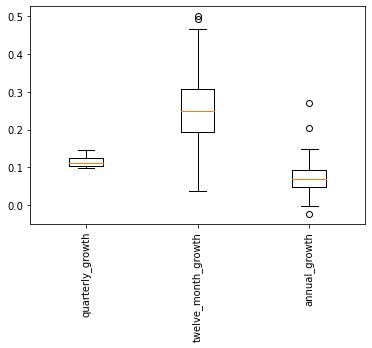

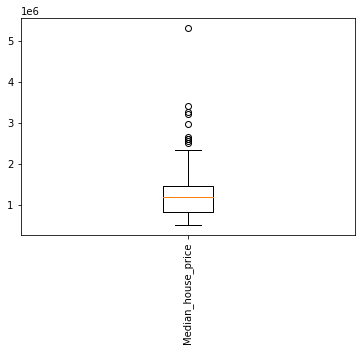

In [35]:
def box_plots(df):
# boxplot for features
    plot1 = df[['House_quarterly_growth','House_twelve_month_growth','House_average_annual_growth']]
    plt.boxplot(plot1)
    plt.xticks([1, 2, 3], ['quarterly_growth','twelve_month_growth','annual_growth'],rotation='vertical')
    plt.show()
    plt.boxplot(df['Median_house_price'])
    plt.xticks([1],['Median_house_price'],rotation='vertical')
    plt.show()
box_plots(part2_df)

### Normalization/Standardization/transformation

- Standardization use StandardScaler for standardization. It is much less affected by outliers. useful when the feature distribution is normal distributed 

- Normalization use MinMaxScaler for Normalization, it is affected by outliers, but this is multi-variable linear regression, drop value by one feature may lead to more outliers on other features, so I will use RobustScaler instead

- On the other hand, the data is skewed, I want to try some transformations, for example, log and square root tranformations are good for skewed data, logit transformation is good for percents, reciprocal can reduce the effect of outliers

- Median_house_price and House_quarterly_growth are seem to be a good fit for using box-cox

### 2.4 Scaling <a class="anchor" id="task24"></a>

In [36]:
# create scalers
Standard_scaler = preprocessing.StandardScaler()
Robust_scaler = preprocessing.RobustScaler()
MinMax_scaler = preprocessing.MinMaxScaler()

robust_df = Robust_scaler.fit_transform(part2_df)
Standard_df=Standard_scaler.fit_transform(part2_df)
MinMax_df = MinMax_scaler.fit_transform(part2_df)

# create scaled dataframe
robust_df = pd.DataFrame(robust_df, columns =['Median_house_price','House_quarterly_growth','House_twelve_month_growth',
                                              'House_average_annual_growth'])
Standard_df=pd.DataFrame(Standard_df, columns =['Median_house_price','House_quarterly_growth','House_twelve_month_growth',
                                                'House_average_annual_growth'])
MinMax_df=pd.DataFrame(MinMax_df, columns =['Median_house_price','House_quarterly_growth','House_twelve_month_growth',
                                            'House_average_annual_growth'])

- as expected, robustscaler is the best choice for scaling 

- From the figure we can see that the visualization before scaling is very difficult, that's why we need to scale the data to improve the data visualization

- Another reason is support vector machines or k-nearest neighbor algorithms, they cannot differentiate the importance of variables, for example, they may think that a difference in distance of one meter is as important as a 100% change is a percentage

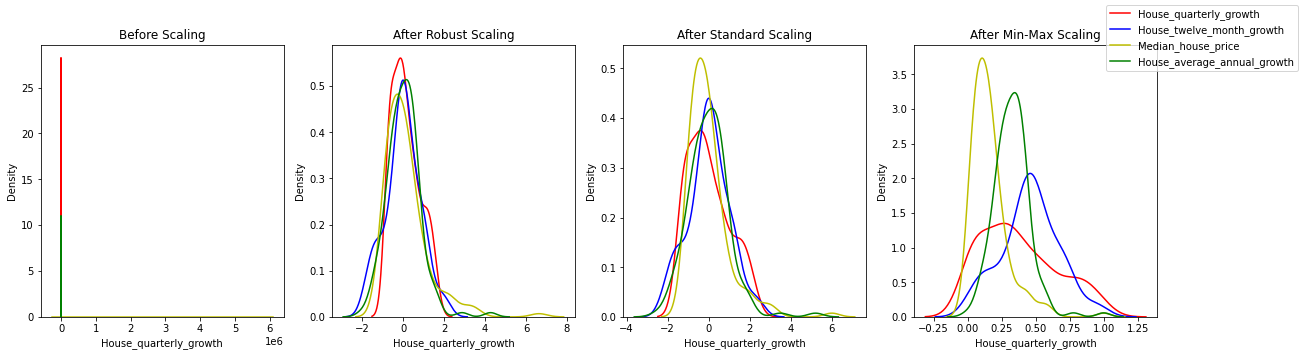

In [37]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
# plot for data before scaling 
ax1.set_title('Before Scaling')
sns.kdeplot(part2_df['House_quarterly_growth'].astype(float), ax = ax1, color ='r')
sns.kdeplot(part2_df['House_twelve_month_growth'].astype(float), ax = ax1,color ='b')
sns.kdeplot(part2_df['Median_house_price'].astype(float), ax = ax1, color ='y')
sns.kdeplot(part2_df['House_average_annual_growth'].astype(float), ax = ax1,color ='g')
# plot for data After Robust Scaling
ax2.set_title('After Robust Scaling')
sns.kdeplot(robust_df['House_quarterly_growth'],  ax = ax2, color ='red')
sns.kdeplot(robust_df['House_twelve_month_growth'],  ax = ax2, color ='blue')
sns.kdeplot(robust_df['Median_house_price'], ax = ax2, color ='y')
sns.kdeplot(robust_df['House_average_annual_growth'], ax = ax2,color ='g')
# plot for data After Standard Scaling 
ax3.set_title('After Standard Scaling')
sns.kdeplot(Standard_df['House_quarterly_growth'],  ax = ax3, color ='red')
sns.kdeplot(Standard_df['House_twelve_month_growth'],  ax = ax3, color ='blue')
sns.kdeplot(Standard_df['Median_house_price'], ax = ax3, color ='y')
sns.kdeplot(Standard_df['House_average_annual_growth'], ax = ax3,color ='g')
# plot for data After Min-Max Scaling
ax4.set_title('After Min-Max Scaling')
sns.kdeplot(MinMax_df['House_quarterly_growth'],  ax = ax4, color ='red')
sns.kdeplot(MinMax_df['House_twelve_month_growth'],  ax = ax4, color ='blue')
sns.kdeplot(MinMax_df['Median_house_price'], ax = ax4, color ='y')
sns.kdeplot(MinMax_df['House_average_annual_growth'], ax = ax4,color ='g')
fig.legend(labels=['House_quarterly_growth','House_twelve_month_growth','Median_house_price','House_average_annual_growth'])
plt.show()

### 2.5 Transformations <a class="anchor" id="task25"></a>

- This process will change the shape of the data to make it more normally distributed. Useful when algorithms require normally distributed data, e.g. t-test, linear regression

#### log, square root, reciprocal

In [38]:
log_skew = list(part2_df.transform([np.log]).skew())

sqrt_skew = list(part2_df.transform([np.sqrt]).skew())

reciprocal_skew = list(part2_df.transform([np.reciprocal]).skew())

#### logit

In [39]:
logit_skew = list(logit(part2_df).skew())

#### box-cox

In [40]:
#House_average_annual_growth has negative value
boxcox_df = part2_df.drop(part2_df[ part2_df['House_average_annual_growth'] < 0 ].index)
box_cox = [stats.skew(list(stats.boxcox(boxcox_df['Median_house_price'])[0])),
           stats.skew(list(stats.boxcox(boxcox_df['House_quarterly_growth'])[0])) ,
          stats.skew(list(stats.boxcox(boxcox_df['House_twelve_month_growth'])[0])),
           stats.skew(list(stats.boxcox(boxcox_df['House_average_annual_growth'])[0]))]
stats.boxcox(boxcox_df['Median_house_price'])
# create a dataframe for boxcox
boxcox_trans = pd.DataFrame([stats.boxcox(boxcox_df['Median_house_price'])[0].tolist(),
                             stats.boxcox(boxcox_df['House_quarterly_growth'])[0].tolist(),
                             stats.boxcox(boxcox_df['House_twelve_month_growth'])[0].tolist(),
                            stats.boxcox(boxcox_df['House_average_annual_growth'])[0].tolist()]).T
column =['Median_house_price','House_quarterly_growth','House_twelve_month_growth','House_average_annual_growth']
boxcox_trans.columns = column

data after normalisation


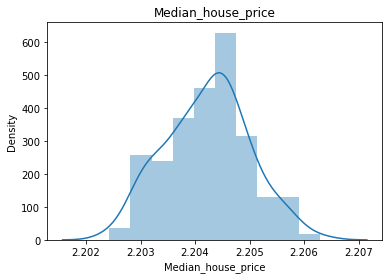

the skewness is :  0.022506086746665255


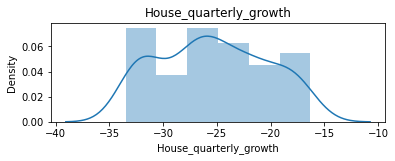

the skewness is :  0.07364825511232198


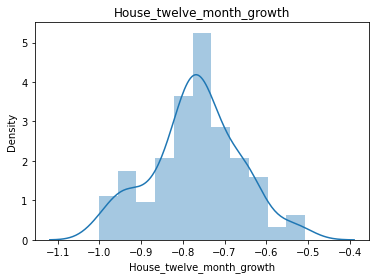

the skewness is :  -0.06934193718760916


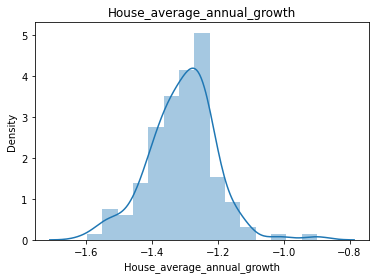

the skewness is :  0.12366548885389078


,features,origin_skew,log_skew,sqrt_skew,reciprocal_skew,logit_skew,box_cox
0,Median_house_price,2.412599,0.566214,1.344727,0.0,NaN,0.022264
1,House_quarterly_growth,0.531936,0.368502,0.449992,-0.207912,0.390178,0.072857
2,House_twelve_month_growth,-0.003418,-1.441958,-0.672863,3.284234,-1.072174,-0.068597
3,House_average_annual_growth,1.111667,-2.371425,-0.24491,9.706821,-2.16633,0.122337


In [41]:
features = ['Median_house_price','House_quarterly_growth','House_twelve_month_growth','House_average_annual_growth']
origin_skew = list(part2_df.skew())
skew_df =[features,origin_skew,log_skew,sqrt_skew,reciprocal_skew,logit_skew,box_cox]
skewness = pd.DataFrame(skew_df).T 
column =['features','origin_skew','log_skew','sqrt_skew','reciprocal_skew','logit_skew','box_cox']
skewness.columns = column
print('data after normalisation')
plot_hists(boxcox_trans)
skewness

- According to the skewness table, box_cox is the best choice to normalise data

### 2.6 linear relationship between features and House_quarterly_growth <a class="anchor" id="task26"></a>

#### not scaled

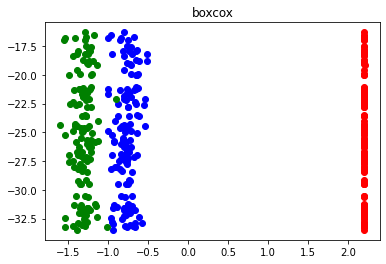

which also shows why we need scaling for beter interpretability 


In [42]:
def scatter_plots(df,title):
    plt.scatter(x=df['House_twelve_month_growth'],y=df['House_quarterly_growth'],c='b')
    plt.scatter(x=df['House_average_annual_growth'],y=df['House_quarterly_growth'],c='g')
    plt.scatter(x= df['Median_house_price'],y=df['House_quarterly_growth'],c='r')
    plt.title(title)
    plt.show()
part2_df.transform([np.sqrt])['Median_house_price']
scatter_plots(boxcox_trans,'boxcox')
print('which also shows why we need scaling for beter interpretability ')

#### robust scaler

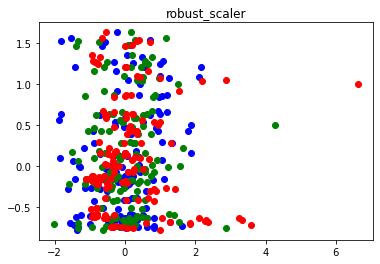

In [43]:

#robust_df  = robust_df.drop(robust_df[robust_df['Median_house_price']== max(robust_df['Median_house_price'])].index)
#robust_df  = robust_df.drop(robust_df[robust_df['House_quarterly_growth']== max(robust_df['House_quarterly_growth'])].index)
#robust_df  = robust_df.drop(robust_df[robust_df['House_twelve_month_growth']== max(robust_df['House_twelve_month_growth'])].index)
scatter_plots(robust_df,'robust_scaler')

#### minmax scaler

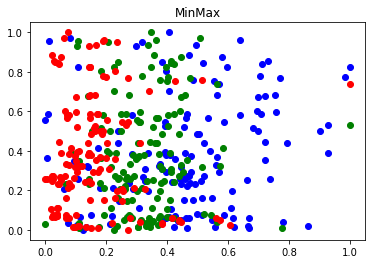

In [44]:
scatter_plots(MinMax_df,'MinMax')

#### standatd scaler

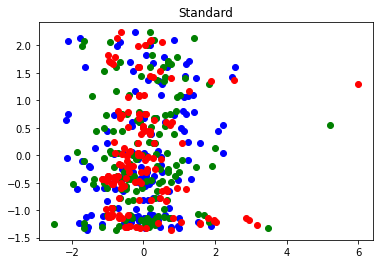

In [45]:
scatter_plots(Standard_df,'Standard')

#### apply robust scaler on box-cox transfered data

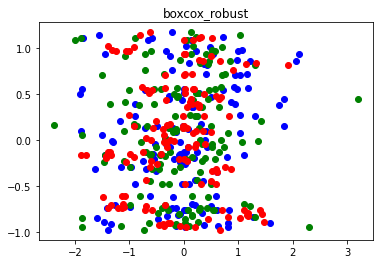

In [46]:
boxcox_robust_df = Robust_scaler.fit_transform(boxcox_trans)
boxcox_robust_df = pd.DataFrame(boxcox_robust_df, columns =['Median_house_price','House_quarterly_growth','House_twelve_month_growth','House_average_annual_growth'])
scatter_plots(boxcox_robust_df,'boxcox_robust')

### 2.7 Regression test <a class="anchor" id="task2_7"></a>

In [47]:
#implement the training function 
def _lr_train(part2_df,method):
    #create test
    X_train, X_test, y_train, y_test = train_test_split(part2_df[['Median_house_price','House_twelve_month_growth',
                                                                  'House_average_annual_growth']],
                                  part2_df['House_quarterly_growth'], test_size=0.3, random_state=1)
    #regression model
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    test_score = lr.score(X_test,y_test)
    #print score
    print('after {} process'.format(method))
    print('test_score:',test_score )
    print('-'*40)
_lr_train(part2_df,'not scaled data')
_lr_train(boxcox_trans,'boxcox')
_lr_train(MinMax_df,'MinMax_scaler')
_lr_train(Standard_df,'Standard')
_lr_train(robust_df,'Robust')
_lr_train(boxcox_robust_df,'boxcox_robust')

after not scaled data process
test_score: -0.2020983193565098
----------------------------------------
after boxcox process
test_score: -0.03295549076847548
----------------------------------------
after MinMax_scaler process
test_score: -0.20209831935650957
----------------------------------------
after Standard process
test_score: -0.20209831935650957
----------------------------------------
after Robust process
test_score: -0.2020983193565098
----------------------------------------
after boxcox_robust process
test_score: -0.032955490768475926
----------------------------------------


- they are not appropriate features to predict House_quarterly_growth, box-cox transformation slightly improved the test score

## Generate output

In [48]:
df.to_csv('32073119_A3_solution.csv', index=False)

## Reference: <a class="anchor" id="reference"></a>

#### estate website link

- https://www.yourinvestmentpropertymag.com.au/

#### Haversine formula

- https://en.wikipedia.org/wiki/Haversine_formula